### Test object detection using remote camer server, cleint

#### Run shared detector on bash
```bash
python3 /home/kiro-ros/Projects/rnb-planning/src/scripts/demo_202107/demo_utils/shared_detector.py
```


#### Run remote camera streaming server (robot-side pc)
```bash
python cam_grpc_sever.py
```

In [1]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import grpc
import cam_stream_grpc.RemoteCam_pb2
import cam_stream_grpc.RemoteCam_pb2_grpc
from cam_stream_grpc.cam_grpc_client import *

sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202208'))

In [2]:
CONNECT_CAM = False
ENABLE_DETECT = True

### Server - Client to get camera image

In [3]:
# generate cam client
cam_client = RemoteCam_Client()

Initialize Client Class to receive color, depth image from remote camera server
+++++ Success to receive camera config +++++


In [4]:
# get camera configuraiton
config = cam_client.get_camera_config()

+++++ Success to receive camera config +++++


In [9]:
# get color, depth image
color, depth = cam_client.get_image()

 +++++ Success to receive color, depth image +++++


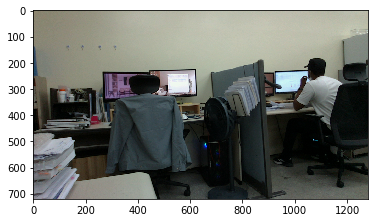

In [12]:
plt.imshow(color[:,:,[2,1,0]])

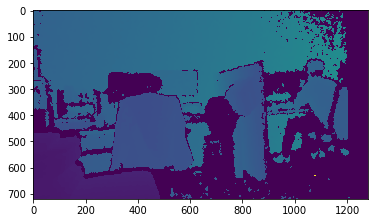

In [13]:
plt.imshow(depth)

### MultiIcp Detection

#### MaskRCNN

In [6]:
# shared detector
from scripts.demo_202208.demo_utils.shared_detector import SharedDetectorGenerator
sd = SharedDetectorGenerator(tuple(reversed(cam_client.img_dim))+(3,))()

if ENABLE_DETECT:
    sd.init()

In [11]:
# inference through CasCade MaskRCNN
mask_out_list = cam_client.inference(sd, color)

#### ICP

In [8]:
from scripts.demo_202208.indy_utils.indydcp_client import IndyDCPClient

server_ip = "localhost"
robot_name = "NRMK-Indy7"
robot_type = "left"

In [11]:
# generate indydcp client
indy = IndyDCPClient(server_ip, robot_name, robot_type)

In [ ]:
# Read current robot state (joint value)
indy.connect()
pos_cur = indy.get_joint_pos()
print("Current robot pos[deg]: \n", pos_cur)
pos_cur = np.deg2rad(pos_cur)

In [ ]:
## Tc 계산해서 받아오기

In [ ]:
# object info
from scripts.demo_202208.cam_stream_grpc.demo_utils.config import *

obj_info_dict = get_obj_info()
micp_bed = MultiICP_Obj(obj_info_dict["bed"], None,
                        OffsetOnModelCoord("bed", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)
mrule_closet.update_rule = ClosetRuleFun(mrule_closet)
micp_closet = MultiICP_Obj(obj_info_dict["closet"], 
                           mrule_closet,
                           OffsetOnModelCoord("closet", 
                                             offset=(0, 1, 0.3),
                                             use_median=True
                                     ))

micp_sofa = MultiICP_Obj(obj_info_dict["couch"], None,
                        OffsetOnModelCoord("couch", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))

micp_refri = MultiICP_Obj(obj_info_dict["refrigerator"], None,
                        OffsetOnModelCoord("refrigerator", R=np.matmul(T_cb[:3, :3], Rot_axis(3, np.pi/2)),
                                          offset=np.matmul(T_cb[:3, :3], (1.1 * 0.5, 0, -0.5))))


micp_dict = {"bed": micp_bed, "closet": micp_closet, "couch": micp_sofa, "refrigerator":micp_refri}

In [ ]:
# initial guess for ICP (object location from kiro)

Tbo_bed = np.identity(4)
Tbo_closet = np.identity(4)
Tbo_sofa = np.identity(4)
Tbo_refri = np.identity(4)

initial_list = {"bed":Tbo_bed, "closet":Tbo_closet, "sofa":Tbo_sofa, "refrigerator":Tbo_refri,}

In [ ]:
micp.set_config(micp_dict, sd, crob, viewpoint, initial_list)

In [ ]:
# # option to detect
# micp.set_ICP_thres(thres_ICP=0.6, thres_front_ICP=0.18)
# micp.set_pcd_ratio(ratio=0.5)
# micp.set_inlier_ratio(ratio=0.02)
# # micp.set_multiobject_num(num = 1)
# micp.set_merge_mask(merge=True)

In [ ]:
# detect
# micp.detect(sd, Tc, "bed")
# micp.detect(sd, Tc, "closet")
# micp.detect(sd, Tc, "sofa")
# micp.detect(sd, Tc, "refrigerator")